# Notebook 5 - Finding cloud frequency using spectral thresholds

Using Notebook 4 (goes_eval_w_camera), we have found a combination of thresholds using a decision tree to identify cloudy vs. clear pixels in GOES data.

In [11]:
import pandas as pd
import numpy as np
import rasterio
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Calculate cloud frequency and sum monthly

In [2]:
def daily_cloud_frequency(year, month, state, goes):
    if month == '07':
        end_day = 32
        if state == 'washington':
            start_day = 13
        else:
            start_day = 1
    elif month == '08':
        start_day = 1
        end_day = 32
    elif month == '09':
        start_day = 1
        end_day = 31

    
    for day in range(start_day, end_day):    
        date = f'{year}{month}' + str(day).zfill(2)
        path = f'/storage/cdalden/goes/{state}/{goes}/rgb_composite/'
        file = f'{goes}_C02_C05_C13_rgb_{state}_{date}.nc'.format(date=date)

        ds = xr.open_dataset(path + file)

        # Make mask for cloud/no cloud
        clouds = xr.where((ds.red > 0.07) & (ds.green > 0.19), 1, 0) # cloud (1) if all conds are met, not cloud (0) otherwise
        ds['clouds'] = clouds

        # Select the time range between 0000-0300 and 1400-2359
        cloud_frequency = ds.clouds.sel(
            t=((ds['t'].dt.hour >= 0) & (ds['t'].dt.hour < 3)) | (ds['t'].dt.hour >= 14)
        ).sum(dim='t')
        cloud_counts = xr.Dataset(
            {'cloud_frequency': (['latitude', 'longitude'], cloud_frequency.data)},
            coords={'latitude': ds.latitude, 'longitude': ds.longitude}
        )

        # Save the cloud frequency data to a NetCDF file
        out_path = f'/storage/cdalden/goes/{state}/{goes}/cloud_counts/'
        out_file = f'{goes}_cloud_frequency_{state}_{date}.nc'.format(date=date)
        cloud_counts.to_netcdf(out_path + out_file)
        print(f"Processed and saved cloud frequency for {date}")

In [3]:
def process_monthly_data(year, month, state, goes, save_file=False):
    
    if month == '07':
        end_day = 32
        if state == 'washington':
            start_day = 13
        else:
            start_day = 1
    elif month == '08':
        start_day = 1
        end_day = 32
    elif month == '09':
        start_day = 1
        end_day = 31

    # Define the date range and file path
    path = f'/storage/cdalden/goes/{state}/{goes}/cloud_counts/'
    file_name_template = f'{goes}_cloud_frequency_{state}_' + '{date}.nc'

    # Generate the list of file paths and corresponding times
    file_paths = []
    times = []
    for day in range(start_day, end_day):  # Days 1 to 30
        date = f'{year}{month}{str(day).zfill(2)}'  # Format the date as '202209DD'
        file_paths.append(path + file_name_template.format(date=date))
        times.append(pd.Timestamp(f'{year}-{month}-{str(day).zfill(2)}'))  # Create a timestamp for each day

    # Open all files and add the time dimension
    datasets = []
    for file, time in zip(file_paths, times):
        ds = xr.open_dataset(file)
        ds = ds.expand_dims(time=[time])  # Add the time dimension
        datasets.append(ds)

    # Combine all datasets along the time dimension
    combined_ds = xr.concat(datasets, dim='time')

    # Compute the sum across the time dimension
    monthly_sum = combined_ds['cloud_frequency'].sum(dim='time')

    # Add the monthly sum as a new variable to the dataset
    combined_ds['monthly_sum'] = monthly_sum

    # monthly frequency 
    combined_ds['monthly_frequency'] = combined_ds['monthly_sum'] / (156*30)  # Assuming 156 observations per day for 30 days

    if save_file:
        combined_ds.to_netcdf(path + f'{goes}_monthly_cloud_frequency_{state}_{year}{month}.nc')
        print(f"Saved monthly cloud frequency data for month {month}")
    
    return combined_ds


### Run the functions

In [4]:
year = '2022'
state = 'colorado'
goes = 'goes16'
months_list = ['07', '08']
# for month in months_list:
    # daily_cloud_frequency(year,month, state, goes)

In [5]:
# Define the months and their corresponding variable names
months_dict = {'07': 'jul_cloud_freq', '08': 'aug_cloud_freq'}
# Dictionary to store the datasets
cloud_freq_datasets = {}

# Loop through the months and process the data
for month, var_name in months_dict.items():
    ds = process_monthly_data(year, month, state, goes, save_file=True)  # Process the data for the month
    cloud_freq_datasets[var_name] = ds  # Save the dataset with the variable name as the key

# Access the datasets
jul_cloud_freq = cloud_freq_datasets['jul_cloud_freq']
aug_cloud_freq = cloud_freq_datasets['aug_cloud_freq']

aug_cloud_freq


Saved monthly cloud frequency data for month 07
Saved monthly cloud frequency data for month 08


<xarray.Dataset> Size: 163MB
Dimensions:            (time: 31, latitude: 640, longitude: 966)
Coordinates:
  * time               (time) datetime64[ns] 248B 2022-08-01 ... 2022-08-31
  * latitude           (latitude) float64 5kB 41.0 40.99 40.99 ... 37.01 37.0
  * longitude          (longitude) float64 8kB -109.0 -109.0 ... -104.0 -104.0
Data variables:
    cloud_frequency    (time, latitude, longitude) int64 153MB 47 47 47 ... 0 0
    monthly_sum        (latitude, longitude) int64 5MB 910 910 896 ... 961 978
    monthly_frequency  (latitude, longitude) float64 5MB 0.1944 0.1944 ... 0.209

In [6]:
# sep_minus_aug = sep_cloud_freq['monthly_frequency'] - aug_cloud_freq['monthly_frequency']
aug_minus_jul = aug_cloud_freq['monthly_frequency'] - jul_cloud_freq['monthly_frequency']

## Plots

In [12]:
# Path to the DEM file
dem_path = "colorado_dem.tif"

# Open the DEM file
with rasterio.open(dem_path) as src:
    elevation = src.read(1)  # Read the first band (elevation data)
    bounds = src.bounds      # Get the bounds of the DEM
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    print(elevation)

[[2543 2536 2526 ... 1626 1626 1626]
 [2541 2542 2531 ... 1627 1625 1626]
 [2539 2546 2546 ... 1626 1623 1624]
 ...
 [1476 1471 1472 ... 1867 1864 1863]
 [1441 1440 1442 ... 1865 1866 1864]
 [1424 1425 1426 ... 1868 1866 1866]]


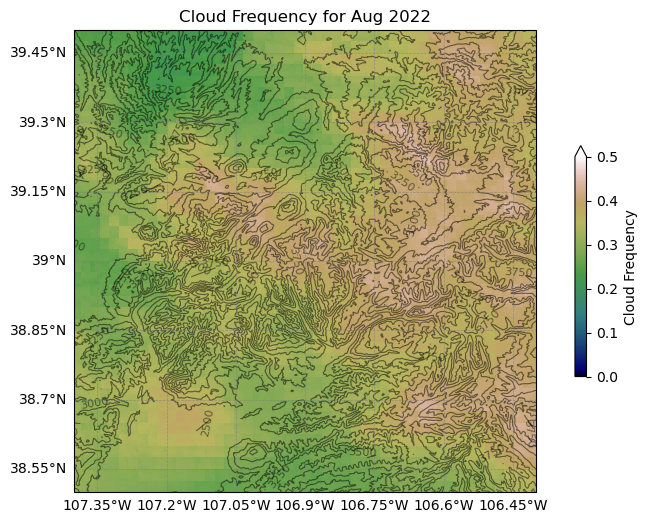

In [24]:
# Create the plot with Cartopy projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for geographic data

# Plot the data
aug_cloud_freq.monthly_frequency.plot(
    ax=ax, 
    cmap="gist_earth",  
    transform=ccrs.PlateCarree(),  # Specify the data's coordinate system
    cbar_kwargs={'label': 'Cloud Frequency', 'shrink': 0.5},
    vmin=0, vmax=0.5  # Set color scale limits
)

# Add elevation contours
contour_levels = np.arange(2500, 4000, 250)  # Define contour levels (e.g., 1000m to 4000m)
elevation_masked = np.ma.masked_invalid(elevation)  # Mask invalid elevation values
contour = ax.contour(
    elevation_masked, 
    levels=contour_levels, 
    colors='black', 
    linewidths=0.8, 
    transform=ccrs.PlateCarree(), 
    extent=extent,
    alpha=0.5  # Set transparency for contours
)
ax.clabel(contour, inline=True, fontsize=8, fmt='%d')  # Add labels to contours



# Add state outlines and coastlines
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor="black")
ax.add_feature(cfeature.RIVERS)
# Add gridlines with latitude and longitude labels
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gridlines.top_labels = False  # Disable top labels
gridlines.right_labels = False  # Disable right labels
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}


# Add title and labels
plt.title(f"Cloud Frequency for Aug 2022")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

ax.set_extent([-107.4, -106.4, 38.5, 39.5], crs=ccrs.PlateCarree())  # east riverish extent

# Show the plot
plt.show()

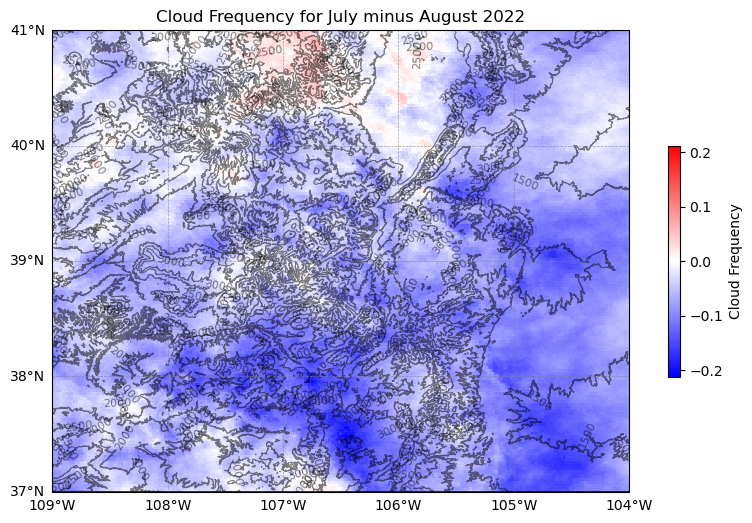

In [18]:
# Create the plot with Cartopy projection
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for geographic data

# Plot the cloud frequency data
aug_minus_jul.plot(
    ax=ax, 
    cmap="bwr",  
    transform=ccrs.PlateCarree(),  # Specify the data's coordinate system
    cbar_kwargs={'label': 'Cloud Frequency', 'shrink': 0.5}
)

# Add elevation contours
contour_levels = np.arange(1000, 4000, 500)  # Define contour levels (e.g., 1000m to 4000m)
elevation_masked = np.ma.masked_invalid(elevation)  # Mask invalid elevation values
contour = ax.contour(
    elevation_masked, 
    levels=contour_levels, 
    colors='black', 
    linewidths=0.8, 
    transform=ccrs.PlateCarree(), 
    extent=extent,
    alpha=0.5  # Set transparency for contours
)
ax.clabel(contour, inline=True, fontsize=8, fmt='%d')  # Add labels to contours


# Add state outlines and coastlines
ax.add_feature(cfeature.COASTLINE, linewidth=1, edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='black')
# Add gridlines with latitude and longitude labels
gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gridlines.top_labels = False  # Disable top labels
gridlines.right_labels = False  # Disable right labels
gridlines.xlabel_style = {'size': 10, 'color': 'black'}
gridlines.ylabel_style = {'size': 10, 'color': 'black'}


# Add title and labels
plt.title(f"Cloud Frequency for July minus August 2022")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

## Get DEM